In [ ]:
from dcmrtstruct2nii.adapters.convert.rtstructcontour2mask import DcmPatientCoords2Mask
from dcmrtstruct2nii.adapters.convert.filenameconverter import FilenameConverter
from dcmrtstruct2nii.adapters.input.contours.rtstructinputadapter import RtStructInputAdapter
from dcmrtstruct2nii.adapters.input.image.dcminputadapter import DcmInputAdapter
from dcmrtstruct2nii.adapters.output.niioutputadapter import NiiOutputAdapter
from dcmrtstruct2nii.exceptions import PathDoesNotExistException, ContourOutOfBoundsException
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pydicom
import scipy.ndimage
from skimage import measure, morphology

In [ ]:
# Creating functions to be used later
def normalize(image,MIN_BOUND,MAX_BOUND):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1
    image[image<0] = 0.
    return image

In [ ]:
dicom_file = '../imagedata/test_dicom/135226/'
rtstruct_file = '../imagedata/RTstrFiles/RS.135226.dcm'
rtreader = RtStructInputAdapter()
dcm_patient_coords_to_mask = DcmPatientCoords2Mask()

In [ ]:
dicom_image = DcmInputAdapter().ingest(dicom_file)
rtstructs = rtreader.ingest(rtstruct_file)

In [ ]:
rtstruct_contours = rtstructs[0]['sequence']

In [ ]:
dcm_patient_coords_to_mask = DcmPatientCoords2Mask()

In [ ]:
dicom_image.GetOrigin()

In [ ]:
for contour in rtstruct_contours:
    if contour['type'].upper() not in ['CLOSED_PLANAR', 'INTERPOLATED_PLANAR']:
        if 'name' in contour:
            logging.info(f'Skipping contour {contour["name"]}, unsupported type: {contour["type"]}')
        else:
            logging.info(f'Skipping unnamed contour, unsupported type: {contour["type"]}')
        continue

    coordinates = contour['points']

    pts = np.zeros([len(coordinates['x']), 3])

    for index in range(0, len(coordinates['x'])):
        # lets convert world coordinates to voxel coordinates
        world_coords = dicom_image.TransformPhysicalPointToIndex((coordinates['x'][index], coordinates['y'][index], coordinates['z'][index]))
        pts[index, 0] = world_coords[0]
        pts[index, 1] = world_coords[1]
        pts[index, 2] = world_coords[2]

    z = int(pts[0, 2])

In [ ]:
test = np.zeros([len(coordinates['x']), 3])
test.shape

In [ ]:
world_coords

In [ ]:
pts

In [ ]:
mask_background_value = 0
mask_foreground_value = 255
resample = 1
fill_value = 0

In [ ]:
mask = dcm_patient_coords_to_mask.convert(rtstructs[0]['sequence'], 
        dicom_image, mask_background_value, mask_foreground_value)

In [ ]:
mask.CopyInformation(dicom_image)

In [ ]:
msk_array = sitk.GetArrayFromImage(mask)
img_array = sitk.GetArrayFromImage(dicom_image)

In [ ]:
img_array.min()

In [ ]:
msk_array.shape, img_array.shape

In [ ]:
def resample(image_array, dicom_image, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([dicom_image.GetSpacing()[2]] + [dicom_image.GetSpacing()[0]] +
                       [dicom_image.GetSpacing()[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image_array.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image_array.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image_array, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
img_array_resampled = resample(img_array,dicom_image)
msk_array_resampled = resample(msk_array,dicom_image)

In [ ]:
img_array_resampled[0].shape, msk_array_resampled[0].shape

In [ ]:
sliceno = 570
plt.figure(figsize=(24,18))
plt.imshow(msk_array_resampled[0][sliceno,:,:],cmap=plt.cm.bone)
plt.imshow(img_array_resampled[0][sliceno,:,:],alpha=0.7,cmap=plt.cm.gray)

In [ ]:
img_array_resampled[0].max()

In [ ]:
crop_fact = 64
crop_length=64

In [ ]:
result = np.where(msk_array_resampled[0] == 255) # Get the index of elements with value 255
z_min,z_max = result[0].min(),result[0].max()
z_mid = (z_max-z_min)//2 
z_midvalue = z_min + z_mid  # this is the position of the middle most slice along z axis

In [ ]:
result

In [ ]:
z_max

x_values = []
y_values = []

for value in range(z_min,z_max):
    x_val = []
    y_val = []
    for j,val in enumerate(result[0]):
        if val == value:
            x_val.append(result[1][j])
            y_val.append(result[2][j])

    x_midvalues = np.array(x_val)
    y_midvalues = np.array(y_val)
    x_values.append(x_val)
    y_values.append(y_val)

In [ ]:
x1=[]
y1=[]
z1=[]
coords = []
for value in range(z_midvalue-(crop_length//2),z_midvalue+(crop_length//2)):
    x_val = []
    y_val = []
    z_val = []
    for j,val in enumerate(result[0]):
        if val == value:
            x1 = result[1][j]
            y1 = result[2][j]
            z1 = result[0][j]
            x_val.append(x1)
            y_val.append(y1)
            z_val.append(z1) 

    x_val_arr = np.array(x_val)
    y_val_arr = np.array(y_val)
    z_val_arr = np.array(z_val)
    coords.append([np.round(x_val_arr.mean()),np.round(y_val_arr.mean()),np.round(z_val_arr.mean())])

In [ ]:
coords

In [ ]:
nan_list = []
z = len(coords)
for i in range(z):
    if np.isnan(coords[i]).sum() > 0:
        nan_list.append(0)
    else:
        nan_list.append(1)
nan_index = np.where(np.array(nan_list)==0) # index for nan valued cordinates in a list

last_nan = []
first_nan = []
for j in nan_index[0]:
    if j >= nan_list.index(1):
        last_nan.append(j)
    else:
        first_nan.append(j)
final_coords = []       
check=0
for i in range(len(nan_list)):
    if nan_list[i] == 0:
        check=check+1
        if check <= nan_list.index(1):
            final_coords.append(coords[nan_list.index(1)])
        else:
            final_coords.append(coords[last_nan[0]-1])
    else:
        final_coords.append(coords[i])

In [ ]:
crop_coords = []
for coor in final_coords:
    xmin = coor[0] - (crop_fact/2)
    xmax = coor[0] + (crop_fact/2)
    ymin = coor[1] - (crop_fact/2)
    ymax = coor[1] + (crop_fact/2)
    z = coor[2]
    crop_coords.append([xmin,xmax,ymin,ymax,z])

In [ ]:
len(final_coords)

In [ ]:
#MIN_BOUND = img_array.min()
#MAX_BOUND = img_array.max()
MIN_BOUND = -1000
MAX_BOUND = 400
img_array_norm = normalize(img_array_resampled[0],MIN_BOUND,MAX_BOUND)
img_crop = np.zeros((crop_fact,crop_fact,len(final_coords)))

In [ ]:
for i in range(len(crop_coords)):
    img_crop[0:,0:,i] = img_array_norm[ int(crop_coords[i][4]),int(crop_coords[i][0]):int(crop_coords[i][1]),
                                        int(crop_coords[i][2]):int(crop_coords[i][3])]

In [ ]:
np.save('135226.npy',img_crop)

In [ ]:
img_crop.shape

In [ ]:
plt.imshow(img_crop[:,:,24],cmap='gray')

In [2]:
from utilities import utilities
import numpy as np

In [3]:
from utilities import preprocessDICOM

In [4]:
dicom_file = '../imagedata/test_dicom/135226/'
rtstruct_file = '../imagedata/test_dicom/135226/RS.135226.dcm'

In [8]:
img = preprocessDICOM.preprocess(dicom_file,rtstruct_file,zero=True)

/Users/chufalsmacbookpro/project/QARCutilities/utilities/preprocessDICOM.py:99: RuntimeWarning: Mean of empty slice.
  coords.append([np.round(x_val_arr.mean()),np.round(y_val_arr.mean()),np.round(z_val_arr.mean())])
/Users/chufalsmacbookpro/project/image_processing/venv38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
np.save('135226.npy',img)

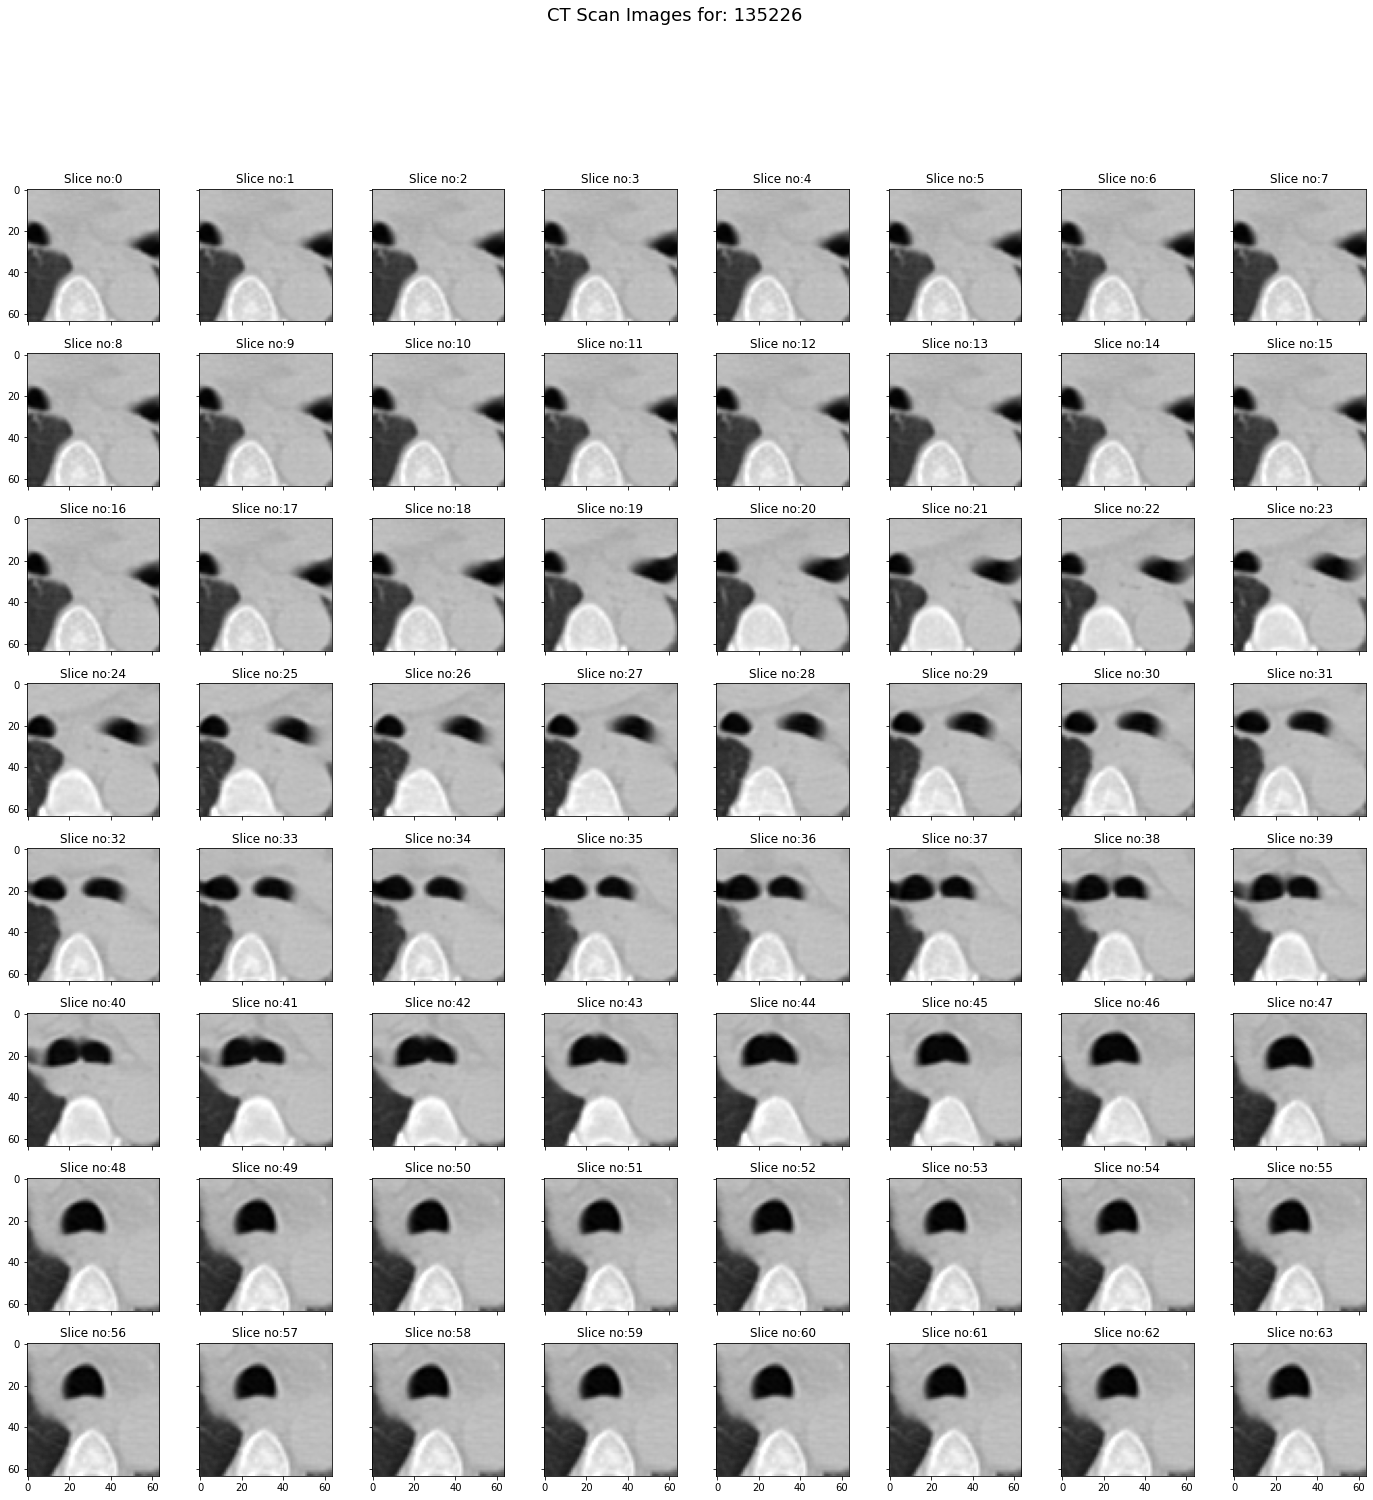

In [10]:
utilities.check_numpy_images(135226,img_path='./',rotate=False)